The contents of this tutorial are heavily adapted from a similar one make by [Savannah Thais](https://github.com/savvy379) using tensorflow and keras.

A graph $G=(N,E)$, comprising nodes $N$ and edges $E$, is a versatile mathematical structure that can represent various data such as molecules, social networks, transportation systems, etc. Nodes and edges may have associated features like geometric or non-geometric information. Graphs can be directed or undirected, and GNNs, with their ability to handle graphs of varying sizes, are well-suited for diverse applications including High Energy Physics (HEP). 

![](toy_graph.png)

GNNs, particularly Graph Convolutional Networks (GCNs), re-embed graph edges and nodes by applying convolution operations to node neighborhoods, unlike the fixed data tensors used in conventional CNNs. This process, termed as "Message Passing," constructs messages by combining information from neighboring nodes, then passes them to target nodes to update features. The entire graph is thus transformed, incorporating valuable information within each node. The convolved graph is often further processed for classification or regression on individual elements or the entire graph. This structure can also be applied to update edge features.

![](message_passing.png)

![](graph_eq.png)

- Initial Embedding: Each node $v$ starts with an initial embedding $h_v^0$, representing the original node features.
- Neighbors: For each node $v$, the neighboring nodes are represented as $N(v)$.
- Message Construction: To update the embedding of node $v$, $h_v^k$, a 'message' is constructed through the following steps:
  1. **Calculate Average of Neighbors' Embeddings**: Take the average over the current embedding of all neighboring nodes: $\sum_{u \in N(v)}\frac{h_u^{k-1}}{\text{deg}(v)}$.
  2. **Optional Target Node Embedding**: Optionally include the current embedding of the target node: $h_v^{k-1}$.
  3. **Apply Function**: Use a function $f$ to combine the above information. In practice, $f$ is approximated by a matrix (convolution) $W^k$.
  4. **Non-linear Activation**: Pass the result through a non-linear activation function to update the target node.
- Result: The entire process transforms the graph, updating the node and possibly edge features to include additional useful information. The final embeddings can then be used for further analysis like classification or regression on the graph's elements or structure.

# Graph Neural Network (GNN) with PyTorch Geometric

In this tutorial, we will implement a Graph Neural Network (GNN) using PyTorch Geometric. We'll use the Cora dataset, which consists of scientific publications as nodes and citation links as edges.

The steps in this tutorial include:
1. Installing PyTorch Geometric
2. Loading the Cora dataset
3. Defining the GNN model
4. Training and evaluating the model
5. Plotting the training loss and test accuracy

Let's get started!


In [1]:
# Step 1: Install PyTorch Geometric
!pip install torch_geometric

## Step 2: Import Libraries and Load Cora Dataset

We'll start by importing the necessary libraries and loading the Cora dataset.

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import numpy as np

[The Cora dataset](https://paperswithcode.com/dataset/cora) consists of **2708 scientific publications** classified into one of **seven classes**. The citation network consists of **5429 links**. Each publication in the dataset is described by a **0/1-valued word vector** indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of **1433 unique words**.

In [3]:
# Load Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

PyTorch Geometric has this nifty class called `Data` which is used to standardize graph data. You can make your own, but since the sample datasets are already in this format, we won't go over how to make them here.

In [4]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [5]:
print("node vectors: \n", data.x,          '\n')
print("node classes:  \n", data.y,          '\n')
print("edge indeces: \n", data.edge_index, '\n\n\n')

print("train_mask: \n", data.train_mask, '\n')
print("val_mask: \n", data.val_mask, '\n')
print("test_mask: \n", data.test_mask, '\n')

node vectors: 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) 

node classes:  
 tensor([3, 4, 4,  ..., 3, 3, 3]) 

edge indeces: 
 tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]]) 



train_mask: 
 tensor([ True,  True,  True,  ..., False, False, False]) 

val_mask: 
 tensor([False, False, False,  ..., False, False, False]) 

test_mask: 
 tensor([False, False, False,  ...,  True,  True,  True]) 



## Step 3: Define the GNN Model

Next, we'll define the GNN model, consisting of two GCN convolution layers.

In [6]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        return x

## Step 4: Training and Evaluation

Now, we'll train the GNN model and evaluate its performance.

In [7]:
# Training and evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(hidden_channels=16).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [8]:
import matplotlib.pyplot as plt


# Lists to store loss and accuracy over time
train_loss_history = []
test_accuracy_history = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())
    return acc

for epoch in range(300):
    loss = train()
    train_loss_history.append(loss)
    accuracy = test()
    test_accuracy_history.append(accuracy)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

print("Test Accuracy:", test())

Epoch: 000, Loss: 1.9487, Accuracy: 0.5430
Epoch: 010, Loss: 0.5831, Accuracy: 0.7720
Epoch: 020, Loss: 0.1152, Accuracy: 0.7910
Epoch: 030, Loss: 0.0307, Accuracy: 0.7810
Epoch: 040, Loss: 0.0135, Accuracy: 0.7890
Epoch: 050, Loss: 0.0162, Accuracy: 0.7860
Epoch: 060, Loss: 0.0153, Accuracy: 0.7900
Epoch: 070, Loss: 0.0202, Accuracy: 0.7940
Epoch: 080, Loss: 0.0180, Accuracy: 0.7970
Epoch: 090, Loss: 0.0184, Accuracy: 0.7970
Epoch: 100, Loss: 0.0168, Accuracy: 0.7960
Epoch: 110, Loss: 0.0176, Accuracy: 0.8010
Epoch: 120, Loss: 0.0160, Accuracy: 0.7990
Epoch: 130, Loss: 0.0154, Accuracy: 0.8000
Epoch: 140, Loss: 0.0150, Accuracy: 0.8040
Epoch: 150, Loss: 0.0125, Accuracy: 0.8050
Epoch: 160, Loss: 0.0141, Accuracy: 0.8020
Epoch: 170, Loss: 0.0121, Accuracy: 0.8080
Epoch: 180, Loss: 0.0136, Accuracy: 0.7990
Epoch: 190, Loss: 0.0132, Accuracy: 0.8070
Epoch: 200, Loss: 0.0102, Accuracy: 0.8030
Epoch: 210, Loss: 0.0115, Accuracy: 0.7990
Epoch: 220, Loss: 0.0117, Accuracy: 0.8060
Epoch: 230,

## Step 5: Plotting Loss and Accuracy

Finally, we'll visualize the training loss and test accuracy using Matplotlib.

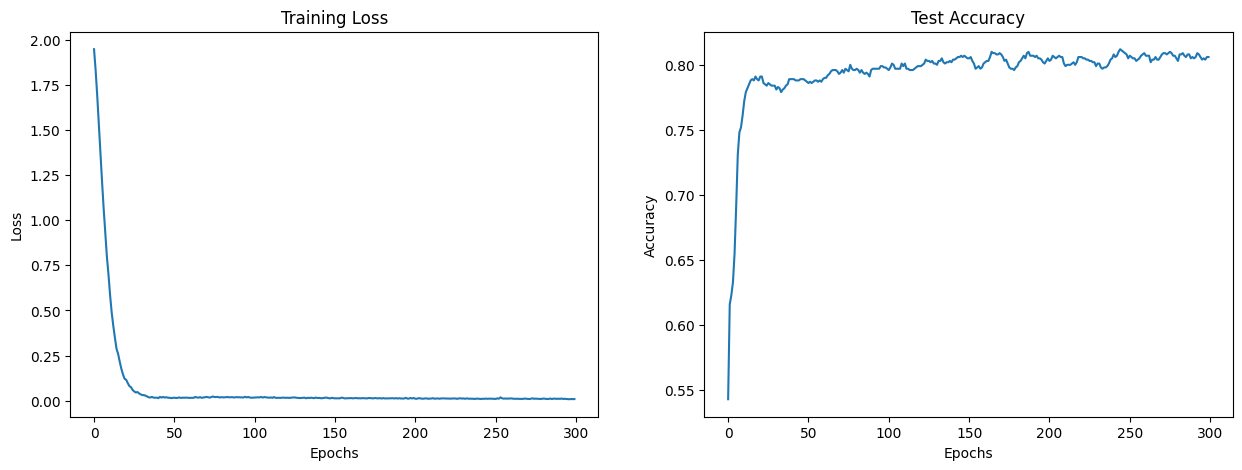

In [9]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss_history)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")

ax2.plot(test_accuracy_history)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Test Accuracy")

plt.show()

## Conclusion

In this tutorial, we implemented a GNN model to classify scientific publications in the Cora dataset. We trained the model and visualized the training progress. Experiment with different hyperparameters and architectures to see how the performance changes!
